## Table of content and model results



## Imports

In [ ]:
!pip install gensim==3.8.3 --quiet

     |████████████████████████████████| 24.2 MB 18.2 MB/s 


In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.4 MB/s 
     |████████████████████████████████| 596 kB 70.8 MB/s 
     |████████████████████████████████| 101 kB 6.6 MB/s 


In [ ]:
!pip install -U tensorflow-text==2.8.2 --quiet

     |████████████████████████████████| 4.9 MB 4.0 MB/s 


In [ ]:
# misc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(42)

# report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

# word2vec
import nltk
import gensim
from nltk.data import find
import tensorflow_text as tf_text

# BERT
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and clean data

In [ ]:
# rename uci data to just data
data = pd.read_csv("/content/drive/MyDrive/W266: SMS Spam Detection Final Project/data/data_clean_trans.csv")
#data = pd.read_csv("/content/drive/MyDrive/W266/data/data_clean_trans.csv")
data

,Unnamed: 0,spam,text,crowd,spanish,language,english
0,0,0,"Go until jurong point, crazy.. Available only ...",0,"Vaya hasta Jurong Point, loco ... disponible s...",en,"Go until jurong point, crazy.. Available only ..."
1,1,0,Ok lar... Joking wif u oni...\n,0,Ok lar ... bromeando wif u oni ...\n,en,Ok lar... Joking wif u oni...\n
2,2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0,Entrada gratuita en 2 una compensación de wkly...,en,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,0,U dun say so early hor... U c already then say...,0,No digo tan temprano hor ... ya c ya digo ...\n,en,U dun say so early hor... U c already then say...
4,4,0,"Nah I don't think he goes to usf, he lives aro...",0,"No, no creo que vaya a la USF, aunque vive por...",en,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...,...,...,...,...
6102,6102,1,You have passed the official certification onl...,1,Ha aprobado la certificación oficial de la aud...,en,You have passed the official certification onl...
6103,6103,1,"Win The Big J@CKP0T Up To 1M PHP! 100 GET 100,...",1,¡Gana la gran j@ckp0t hasta 1 m php! 100 Get 1...,en,"Win The Big J@CKP0T Up To 1M PHP! 100 GET 100,..."
6104,6104,1,"Hi, I'm a Shopee Hiring Manager and I'm curren...",1,"Hola, soy un gerente de contratación de Shopee...",en,"Hi, I'm a Shopee Hiring Manager and I'm curren..."
6105,6105,1,"4 PCS SOLAR LIGHTS FOR ONLY 1,499 !\nPinaka mu...",1,"¡4 PCS Luces solares por solo 1,499!\n¡La mayo...",fil,"4 pcs solar lights for only 1,499!\nMost cheap..."


In [ ]:
data = data.convert_dtypes()
data.dtypes

Unnamed: 0     Int64
spam           Int64
text          string
crowd          Int64
spanish       string
language      string
english       string
dtype: object

## EDA

In [ ]:
sum(data["spam"] == 1)

1280

In [ ]:
sum(data["spam"] == 0)

4827

## Split the data

In [ ]:
X, y = data['english'], data['spam']

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    shuffle=True)

## Helper functions

In [ ]:
def print_metrics(test_name, y_true, y_pred):
    print('%s: accuracy = %.4f, precision = %.4f, recall = %.4f, f1 = %.4f'
          % (test_name,
             metrics.accuracy_score(y_true, y_pred),
             metrics.precision_score(y_true, y_pred),
             metrics.recall_score(y_true, y_pred),
             metrics.f1_score(y_true, y_pred)))

## Base models

- Word2Vec embeddings
  - CNN
  - LSTM

- BERT embeddings
  - Fully connected network
  - CNN


#### Word2Vec embeddings

In [ ]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [ ]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [ ]:
# creating a Word2Vec embedding
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i



In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_X)
test_tokens = tokenizer.tokenize(test_X)

In [ ]:
train_tokens[0]

<tf.Tensor: shape=(18,), dtype=string, numpy=
array([b"You've", b'won', b'tkts', b'to', b'the', b'EURO2004', b'CUP',
       b'FINAL', b'or', b'\xc2\xa3800', b'CASH,', b'to', b'collect',
       b'CALL', b'09058099801', b'b4190604,', b'POBOX', b'7876150ppm'],
      dtype=object)>

In [ ]:
# TO-DO: make sure this is tuned
MAX_SEQUENCE_LENGTH = 5

In [ ]:
def sents_to_ids(token_list_list, label_list, num_examples=100000000):
    """
    converting a list of strings to a list of lists of word ids
    """
    text_ids = []
    text_labels = []
    example_count = 0
    use_token_list_list = token_list_list[:num_examples]
    for i, token_list in enumerate(use_token_list_list):
        if i < num_examples:
            try:
                example = []
                for token in list(token_list.numpy()):
                    decoded = token.decode('utf-8').replace('.','').replace(',','').replace('!','')
                    try:
                        example.append(vocab_dict[decoded])
                        
                    except:
                        example.append(43981)
                if len(example) >= MAX_SEQUENCE_LENGTH:
                    text_ids.append(example[:MAX_SEQUENCE_LENGTH])
                    text_labels.append(label_list[i])
                    if example_count % 5000 == 0:
                        print('Examples processed: ', example_count)
                    example_count += 1
                else:
                    pass
            except:
                pass

    
    print('Number of examples retained: ', example_count) 
    return (np.array(text_ids),   np.array(text_labels)) 

In [ ]:
# convert to tensor
y_train = tf.convert_to_tensor(list(train_y))
y_test = tf.convert_to_tensor(list(test_y))

In [ ]:
train_input, train_input_labels = sents_to_ids(train_tokens, y_train)
test_input, test_input_labels = sents_to_ids(test_tokens, y_test)

Examples processed:  0
Number of examples retained:  4605
Examples processed:  0
Number of examples retained:  1147


#### CNN

In [ ]:
cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
# Specify model hyperparameters.
epochs = 10
num_filters = [3, 2, 1]
kernel_sizes = [2, 4, 5]
dense_layer_dims = [100, 30]
dropout_rate = 0.5

In [ ]:
cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [ ]:
cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

h = cnn_embeddings

In [ ]:
conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

In [ ]:
h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

In [ ]:
h = keras.layers.Dropout(rate=dropout_rate)(h)

In [ ]:
for dense_layer_dim in dense_layer_dims:  
    h = keras.layers.Dense(dense_layer_dim, activation='relu')(h)

In [ ]:
cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(h)

In [ ]:
cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5, 300)       13194600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 4, 3)         1803        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2, 2)         2402        ['embedding[0][0]']              
                                                                                              

In [ ]:
cnn_history = cnn_model.fit(train_input,
             np.array(train_input_labels),
             validation_data=(test_input, np.array(test_input_labels)),
             batch_size=32,
             epochs=5
             )

Epoch 1/5
144/144 [==============================] - 11s 6ms/step - loss: 0.4677 - accuracy: 0.7798 - val_loss: 0.3992 - val_accuracy: 0.7724
Epoch 2/5
144/144 [==============================] - 1s 4ms/step - loss: 0.3741 - accuracy: 0.8111 - val_loss: 0.3403 - val_accuracy: 0.8779
Epoch 3/5
144/144 [==============================] - 1s 4ms/step - loss: 0.3317 - accuracy: 0.8597 - val_loss: 0.2869 - val_accuracy: 0.8928
Epoch 4/5
144/144 [==============================] - 1s 4ms/step - loss: 0.2999 - accuracy: 0.8723 - val_loss: 0.2667 - val_accuracy: 0.9032
Epoch 5/5
144/144 [==============================] - 1s 4ms/step - loss: 0.2799 - accuracy: 0.8847 - val_loss: 0.2629 - val_accuracy: 0.9015


##### Train report

In [ ]:
dev_pred = cnn_model.predict(train_input)

In [ ]:
test_pred = cnn_model.predict(test_input)

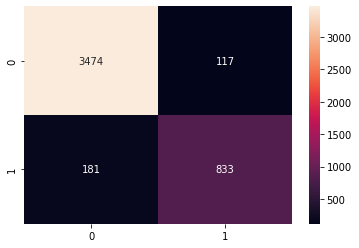

In [ ]:
sns.heatmap(confusion_matrix(np.array(train_input_labels), np.round(dev_pred,0)), annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('W2V + CNN, train data', np.array(train_input_labels), np.round(dev_pred,0))

W2V + CNN, train data: accuracy = 0.9353, precision = 0.8768, recall = 0.8215, f1 = 0.8483


In [ ]:
# TO-DO can't analyze because some texts were discarded during conversion to ids

train_y = train_input_labels
train_y_predict = np.round(dev_pred,0)

##### Test report

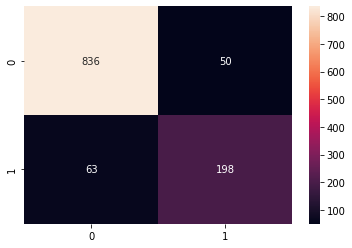

In [ ]:
sns.heatmap(confusion_matrix(np.array(test_input_labels), np.round(test_pred,0)), annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('W2V + CNN, test data', np.array(test_input_labels), np.round(test_pred,0))

W2V + CNN, test data: accuracy = 0.9015, precision = 0.7984, recall = 0.7586, f1 = 0.7780


#### LSTM

In [ ]:
rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1],
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

In [ ]:
def build_classificaiton_rnn_model(rnn_dim):
  """
  max_length:         maximum input length
  rnn_dim:            dimension of the rnn 
  return_sequences:   should the output vectors get returned?  
  return_state:       should the final cell states get returned?
  """
  
  rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

  rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

  # only return the last output from the RNN calculation 
  rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
              (rnn_embeddings)

  rnn_hidden = tf.keras.layers.Dense(100, activation='relu', name='rnn_hidden')(rnn_output)


  rnn_classification = tf.keras.layers.Dense(1, 
                                            activation='sigmoid', 
                                            name='rnn_classification')(rnn_hidden)

  # model definition

  rnn_model = tf.keras.models.Model(inputs=rnn_input_layer, outputs=[rnn_classification])

  rnn_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                  beta_1=0.9,
                                                  beta_2=0.999,
                                                  epsilon=1e-07,
                                                  amsgrad=False,
                                                  name='Adam'),
                  metrics='accuracy')
    
  return rnn_model

In [ ]:
rnn_model = build_classificaiton_rnn_model(rnn_dim=3)

In [ ]:
rnn_history = rnn_model.fit(train_input,
             np.array(train_input_labels),
             validation_data=(test_input, np.array(test_input_labels)),
             batch_size=32,
              epochs=5
             )

Epoch 1/5
144/144 [==============================] - 4s 7ms/step - loss: 0.5227 - accuracy: 0.7796 - val_loss: 0.4312 - val_accuracy: 0.7733
Epoch 2/5
144/144 [==============================] - 1s 4ms/step - loss: 0.3493 - accuracy: 0.8473 - val_loss: 0.3079 - val_accuracy: 0.8692
Epoch 3/5
144/144 [==============================] - 1s 4ms/step - loss: 0.2873 - accuracy: 0.8834 - val_loss: 0.2813 - val_accuracy: 0.8823
Epoch 4/5
144/144 [==============================] - 1s 4ms/step - loss: 0.2636 - accuracy: 0.8982 - val_loss: 0.2695 - val_accuracy: 0.8893
Epoch 5/5
144/144 [==============================] - 1s 4ms/step - loss: 0.2500 - accuracy: 0.9040 - val_loss: 0.2583 - val_accuracy: 0.8893


In [ ]:
dev_pred = rnn_model.predict(train_input)
test_pred = rnn_model.predict(test_input)

##### Train report

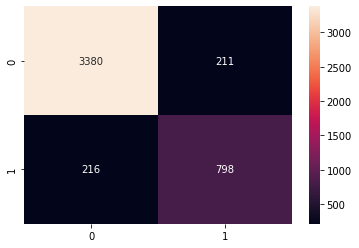

In [ ]:
sns.heatmap(confusion_matrix(np.array(train_input_labels), np.round(dev_pred,0)), annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('W2V + LSTM model, train data: ', np.array(train_input_labels), np.round(dev_pred,0))

W2V + LSTM model, train data: : accuracy = 0.9073, precision = 0.7909, recall = 0.7870, f1 = 0.7889


##### Test report

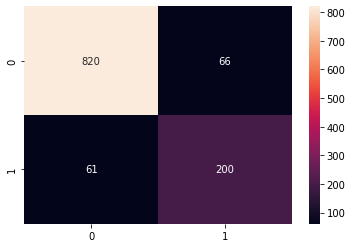

In [ ]:
sns.heatmap(confusion_matrix(np.array(test_input_labels), np.round(test_pred,0)), annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('W2V + LSTM model, test data: ', np.array(test_input_labels), np.round(test_pred,0))

W2V + LSTM model, test data: : accuracy = 0.8893, precision = 0.7519, recall = 0.7663, f1 = 0.7590


#### BERT

In [ ]:
# TO-DO: have to split data again after W2V?
X, y = data['text'], data['spam']

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    shuffle=True)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_length = 100                # set max_length


all_train_examples = list(train_X)
all_test_examples = list(test_X)


x_train = bert_tokenizer(all_train_examples, 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_train = tf.convert_to_tensor(list(train_y))

x_test = bert_tokenizer(all_test_examples, 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_test = tf.convert_to_tensor(list(test_y))

In [ ]:
def create_bert_pooled_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Ouutput for classification purposes
    """

    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # TO-DO: play around with restricting and not restricting BERT layers
    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') #--SOLUTION--
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    ##bert_inputs = {'input_ids': input_ids,
    #              'token_type_ids': token_type_ids,
    #              'attention_mask': attention_mask
    #               }

    #bert_out = bert_model([input_ids, token_type_ids, attention_mask])

    

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 


    
    return classification_model

In [ ]:
pooled_bert_model = create_bert_pooled_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pooled_bert_model_history = pooled_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                                  batch_size=8, 
                                                  epochs=1)  

611/611 [==============================] - 54s 63ms/step - loss: 0.1119 - accuracy: 0.9650 - val_loss: 0.1023 - val_accuracy: 0.9771


In [ ]:
train_predict_labels = pooled_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = train_predict_labels.round(0)

In [ ]:
test_predict_labels = pooled_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

##### Train report

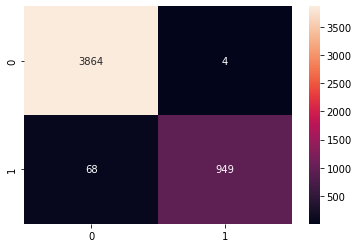

In [ ]:
sns.heatmap(confusion_matrix(np.array(train_y, int), np.array(train_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('BERT + FCN, train data: ', np.array(train_y, int), train_y_predict)

BERT + FCN, train data: : accuracy = 0.9853, precision = 0.9958, recall = 0.9331, f1 = 0.9635


##### Test report

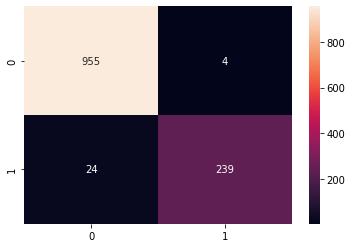

In [ ]:
sns.heatmap(confusion_matrix(np.array(test_y, int), np.array(test_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('BERT + FCN, test data: ', np.array(test_y, int), test_y_predict)

BERT + FCN, test data: : accuracy = 0.9771, precision = 0.9835, recall = 0.9087, f1 = 0.9447


#### BERT Analysis

In [ ]:
train_y_predict = train_y_predict.ravel()

In [ ]:
# spam examples
data['text'][data["spam"] == 1]

2       Free entry in 2 a wkly comp to win FA Cup fina...
5       FreeMsg Hey there darling it's been 3 week's n...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
11      SIX chances to win CASH! From 100 to 20,000 po...
                              ...                        
6102    You have passed the official certification onl...
6103    Win The Big J@CKP0T Up To 1M PHP! 100 GET 100,...
6104    Hi, I'm a Shopee Hiring Manager and I'm curren...
6105    4 PCS SOLAR LIGHTS FOR ONLY 1,499 !
Pinaka mur...
6106    Sissy, 1P lang per bet kay cutt.ly/BingoPlus-P...
Name: text, Length: 1280, dtype: string

In [ ]:
missclassified_text = train_X[train_y != train_y_predict]
missclassified_label = train_y[train_y != train_y_predict]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'missclassified_true_label': missclassified_label})

#df_report['missclassified_true_label'].value_counts()
df_report

,missclassified_text,missclassified_true_label
5037,You won't believe it but it's true. It's Incre...,1
1430,For sale - arsenal dartboard. Good condition b...,1
2115,Sunshine Hols. To claim ur med holiday send a ...,1
2247,Hi ya babe x u 4goten bout me?' scammers getti...,1
5770,I sexually Identify as a Gabe Newell. Ever sin...,1
...,...,...
1235,"""Hello-/@drivby-:0quit edrunk sorry iff pthis ...",0
5797,Globe: You’ve won the Netflix Mug in our Givea...,1
3574,You won't believe it but it's true. It's Incre...,1
2863,Adult 18 Content Your video will be with you s...,1


In [ ]:
#train_X[train_y != train_y_predict].loc[1460]

In [ ]:
df_report.loc[2965]

missclassified_text          Do you ever notice that when you're driving, a...
missclassified_true_label                                                    1
Name: 2965, dtype: object

##### Baseline BERT observations
-----------------------------

As expected more text messages that were SPAM got classified as HAM because HAM is the majority class in our dataset.

I looked at a couple examples of texts that got misclassified as HAM and they're tricky to tell if it's a ham or spam messages. The 2 examples contained generic sayings that even a human could mistakenly classify as spam.


*Let Ur Heart Be Ur Compass Ur Mind Ur Map Ur Soul Ur Guide And U Will Never loose in world....gnun - Sent via WAY2SMS.COM*

*1Apple/Day=No Doctor. 1Tulsi Leaf/Day=No Cancer. 1Lemon/Day=No Fat. 1Cup Milk/day=No Bone Problms 3 Litres Watr/Day=No Diseases Snd ths 2 Whom U Care..:-)*


In general the misclassified messages are hard to tell for certain that they are ham or spam.


#### BERT + CNN

In [ ]:
def create_bert_cnn_model(train_layers=-1,
                          hidden_size = 100, 
                          learning_rate=0.00005,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [3, 5, 10, 20],
                          dense_layer_dims = 100,
                          dropout = 0.3):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    ### YOUR CODE HERE

    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # TO-DO: play around with restricting and not restricting BERT layers
    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # bert_inputs = {'input_ids': input_ids} 
    bert_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[0][:, 1:-1]

    # CNN -----

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(pooled_token)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    #h = keras.layers.Dropout(rate=dropout)(h)

    h = tf.keras.layers.Dense(dense_layer_dims, activation='relu')(h)
    h = tf.keras.layers.Dropout(rate=dropout)(h) 

    # -----

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(h)

    # classification_model = tf.keras.Model(inputs=[input_ids], outputs=[classification])
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy')


    ### END YOUR CODE
    
    return classification_model

In [ ]:
cnn_bert_model = create_bert_cnn_model()

cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            batch_size=8, 
                                            epochs=1)  

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


611/611 [==============================] - 56s 65ms/step - loss: 0.0688 - accuracy: 0.9785 - val_loss: 0.1104 - val_accuracy: 0.9746


In [ ]:
predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = predict_labels.round(0)
test_predict_labels = cnn_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

##### Train report

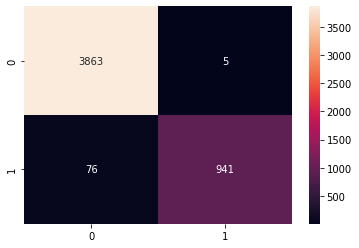

In [ ]:
sns.heatmap(confusion_matrix(np.array(train_y, int), np.array(train_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('BERT + CNN, train data: ', np.array(train_y, int), train_y_predict)

BERT + CNN, train data: : accuracy = 0.9834, precision = 0.9947, recall = 0.9253, f1 = 0.9587


##### Test report

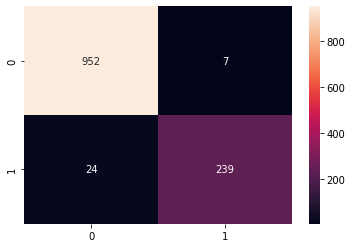

In [ ]:
sns.heatmap(confusion_matrix(np.array(test_y, int), np.array(test_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('BERT + CNN, test data: ', np.array(test_y, int), test_y_predict)

BERT + CNN, test data: : accuracy = 0.9746, precision = 0.9715, recall = 0.9087, f1 = 0.9391


- Train

  - Word2Vec embeddings
    - CNN  |  accuracy = 0.9336, precision = 0.8344, recall = 0.8700, f1 = 0.8519
    - LSTM  |  accuracy = 0.9172, precision = 0.8217, recall = 0.7956, f1 = 0.8085

  - BERT with
    - Fully connected network  |  accuracy = 0.9873, precision = 0.9827, recall = 0.9555, f1 = 0.9689
    - CNN  |  accuracy = 0.9865, precision = 1.0000, recall = 0.9348, f1 = 0.9663

- Test

  - Word2Vec embeddings
    - W2V + CNN, test data: : accuracy = 0.8949, precision = 0.7567, recall = 0.7773, f1 = 0.7669
    - W2V + LSTM model, test data: : accuracy = 0.8897, precision = 0.7452, recall = 0.7656, f1 = 0.7553

  - BERT with
    - BERT + FCN, test data: : accuracy = 0.9885, precision = 0.9841, recall = 0.9611, f1 = 0.9724
    - BERT + CNN, test data: : accuracy = 0.9828, precision = 0.9958, recall = 0.9222, f1 = 0.9576


## Tuned models

#### BERT tuning

**Experiment 1:** Increase the number of epochs because the training kept on improving in the first epoch and we may want to have a couple passes through the model in order to find the most optimal weights for this classification task. Also tune if freezing or unfreezing BERT layers will improve performance. I assume that unfreezing the layers may introduce too many parameters and the model will overfit. But we're expecting the number of epochs to increase performance.

In [ ]:
pooled_bert_model = create_bert_pooled_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pooled_bert_model_history = pooled_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                                  batch_size=8, 
                                                  epochs=3)  

Epoch 1/3
611/611 [==============================] - 53s 61ms/step - loss: 0.0858 - accuracy: 0.9750 - val_loss: 0.1048 - val_accuracy: 0.9763
Epoch 2/3
611/611 [==============================] - 34s 56ms/step - loss: 0.0391 - accuracy: 0.9894 - val_loss: 0.0605 - val_accuracy: 0.9869
Epoch 3/3
611/611 [==============================] - 34s 56ms/step - loss: 0.0536 - accuracy: 0.9853 - val_loss: 0.1682 - val_accuracy: 0.9370


In [ ]:
train_predict_labels = pooled_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = train_predict_labels.round(0)

In [ ]:
test_predict_labels = pooled_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

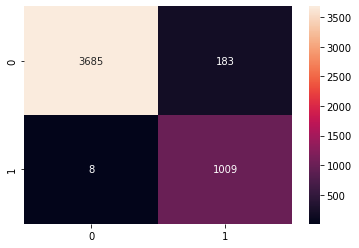

In [ ]:
# train
sns.heatmap(confusion_matrix(np.array(train_y, int), np.array(train_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

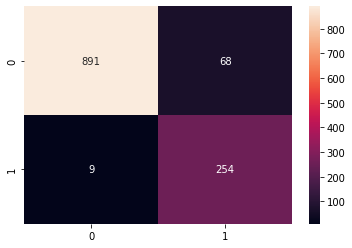

In [ ]:
# test
sns.heatmap(confusion_matrix(np.array(test_y, int), np.array(test_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
# train
print_metrics('BERT 3e + FCN, train data: ', np.array(train_y, int), train_y_predict)

BERT 3e + FCN, train data: : accuracy = 0.9609, precision = 0.8465, recall = 0.9921, f1 = 0.9135


In [ ]:
# test
print_metrics('BERT 3e + FCN, test data: ', np.array(test_y, int), test_y_predict)

BERT 3e + FCN, test data: : accuracy = 0.9370, precision = 0.7888, recall = 0.9658, f1 = 0.8684


In [ ]:
# train
missclassified_text = train_X[train_y != train_y_predict.reshape(-1)]
missclassified_label = train_y[train_y != train_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
838,"Sir, I have been late in paying rent for the p...",0
3430,I don't know jack shit about anything or i'd s...,0
4111,"Yo, you gonna still be in stock tomorrow/today...",0
4491,My computer just fried the only essential part...,0
4529,HOW ARE U? I HAVE MISSED U! I HAVENT BEEN UP 2...,0
...,...,...
323,cud u tell ppl im gona b a bit l8 cos 2 buses ...,0
342,I take it the post has come then! You must hav...,0
1897,I tot u outside cos darren say u come shopping...,0
1159,Hey! There's veggie pizza... :/,0


In [ ]:
# test
missclassified_text = test_X[np.array(test_y, int) != test_y_predict.reshape(-1)]
missclassified_label = test_y[np.array(test_y, int) != test_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
4811,"Honey, can you pls find out how much they sell...",0
893,Nutter. Cutter. Ctter. Cttergg. Cttargg. Ctarg...,0
820,"""BOO BABE! U ENJOYIN YOURJOB? U SEEMED 2 B GET...",0
3044,Your bill at 3 is £33.65 so thats not bad!,0
2663,Hello darling how are you today? I would love ...,1
...,...,...
4016,You will be receiving this week's Triple Echo ...,1
3094,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1...,0
3227,"Rose for red,red for blood,blood for heart,hea...",0
4456,"Storming msg: Wen u lift d phne, u say ""HELLO""...",0


**Experiment 1 Results:** As expected increasing number of epochs slightly improved the f1 score and accuracy. Running it on 3 epochs seemed like a good threshold as the loss function kept decresing but the accuracy stopped improving. We're getting pretty good results with only 18 text messages that got missclassfied from the test.

In [ ]:
# unfreeze layers
pooled_bert_model_unfreeze = create_bert_pooled_model(train_layers=1)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pooled_bert_model_history = pooled_bert_model_unfreeze.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                                  batch_size=8, 
                                                  epochs=3) 

Epoch 1/3
611/611 [==============================] - 32s 41ms/step - loss: 0.0990 - accuracy: 0.9648 - val_loss: 0.0642 - val_accuracy: 0.9804
Epoch 2/3
611/611 [==============================] - 23s 38ms/step - loss: 0.0329 - accuracy: 0.9916 - val_loss: 0.0472 - val_accuracy: 0.9894
Epoch 3/3
611/611 [==============================] - 23s 37ms/step - loss: 0.0228 - accuracy: 0.9928 - val_loss: 0.0601 - val_accuracy: 0.9885


In [ ]:
train_predict_labels = pooled_bert_model_unfreeze.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = train_predict_labels.round(0)

In [ ]:
test_predict_labels = pooled_bert_model_unfreeze.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

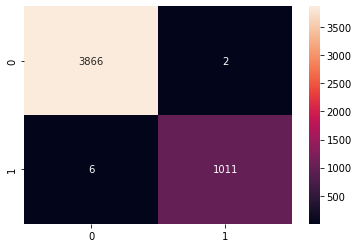

In [ ]:
# train
sns.heatmap(confusion_matrix(np.array(train_y, int), np.array(train_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

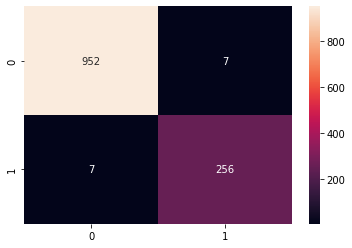

In [ ]:
# test
sns.heatmap(confusion_matrix(np.array(test_y, int), np.array(test_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
# train
print_metrics('BERT 3e + FCN, train data: ', np.array(train_y, int), train_y_predict)

BERT 3e + FCN, train data: : accuracy = 0.9984, precision = 0.9980, recall = 0.9941, f1 = 0.9961


In [ ]:
# test
print_metrics('BERT 3e + FCN, test data: ', np.array(test_y, int), test_y_predict)

BERT 3e + FCN, test data: : accuracy = 0.9885, precision = 0.9734, recall = 0.9734, f1 = 0.9734


In [ ]:
# test
missclassified_text = test_X[np.array(test_y, int) != test_y_predict.reshape(-1)]
missclassified_label = test_y[np.array(test_y, int) != test_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
5738,Hi! Wànt to àvàil Our Pèrsonàl Loàn? Fàst & eà...,1
2663,Hello darling how are you today? I would love ...,1
718,Book which lesson? then you msg me... I will c...,0
263,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0
989,Yun ah.the ubi one say if ü wan call by tomorr...,0
5581,N/a,1
2680,"New Tones This week include: 1)McFly-All Ab..,...",1
4141,Leave it wif me lar... Ü wan to carry meh so h...,0
334,Any chance you might have had with me evaporat...,0
4330,1Apple/Day=No Doctor. 1Tulsi Leaf/Day=No Cance...,0


**Experiment 1 Results:** Unfreezing the BERT model layers helped with increasing the F1 score to 0.9745 on running the model for 3 epochs. The performance on the training set was excellent which may mean that we're slightly overfitting. 

Because the performance kept improving we may try to run on a couple more epochs to see if overfitting becomes worse and see if we will hit lower performance on the validation set.

In [ ]:
# unfreeze layers
pooled_bert_model_unfreeze = create_bert_pooled_model(train_layers=1)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# change to 5 epochs
pooled_bert_model_history = pooled_bert_model_unfreeze.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                                  batch_size=8, 
                                                  epochs=5) 

Epoch 1/5
611/611 [==============================] - 33s 42ms/step - loss: 0.0920 - accuracy: 0.9662 - val_loss: 0.0627 - val_accuracy: 0.9828
Epoch 2/5
611/611 [==============================] - 23s 37ms/step - loss: 0.0318 - accuracy: 0.9908 - val_loss: 0.0645 - val_accuracy: 0.9853
Epoch 3/5
611/611 [==============================] - 22s 37ms/step - loss: 0.0211 - accuracy: 0.9934 - val_loss: 0.0593 - val_accuracy: 0.9861
Epoch 4/5
611/611 [==============================] - 22s 37ms/step - loss: 0.0115 - accuracy: 0.9973 - val_loss: 0.0706 - val_accuracy: 0.9885
Epoch 5/5
611/611 [==============================] - 23s 38ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0666 - val_accuracy: 0.9877


In [ ]:
train_predict_labels = pooled_bert_model_unfreeze.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = train_predict_labels.round(0)

In [ ]:
test_predict_labels = pooled_bert_model_unfreeze.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

In [ ]:
# test
missclassified_text = test_X[np.array(test_y, int) != test_y_predict.reshape(-1)]
missclassified_label = test_y[np.array(test_y, int) != test_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
3044,Your bill at 3 is £33.65 so thats not bad!,0
5667,Keep safe and let me assist you to have a CÀSH...,1
5738,Hi! Wànt to àvàil Our Pèrsonàl Loàn? Fàst & eà...,1
2663,Hello darling how are you today? I would love ...,1
263,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0
989,Yun ah.the ubi one say if ü wan call by tomorr...,0
5581,N/a,1
2680,"New Tones This week include: 1)McFly-All Ab..,...",1
3422,Welcome! Please reply with your AGE and GENDER...,1
2774,How come it takes so little time for a child w...,1


In [ ]:
# train
print_metrics('BERT 5e + FCN, train data: ', np.array(train_y, int), train_y_predict)
# test
print_metrics('test data: ', np.array(test_y, int), test_y_predict)

BERT 5e + FCN, train data: : accuracy = 0.9992, precision = 1.0000, recall = 0.9961, f1 = 0.9980
test data: : accuracy = 0.9877, precision = 0.9844, recall = 0.9582, f1 = 0.9711


**Experiment 1 Results:** Increasing the number of epochs to 5 has resulted in some overfitting, we see a degraded performance on the test set in F1 score and increase in the number of misclassified examples. As a result of this experiment BERT model with unfrozen layers and 3 epochs proved to produce really good results. 

Original untuned model test performance:
accuracy = 0.9828, precision = 0.9797, recall = 0.9377, f1 = 0.9583


Tuned model test performance:
accuracy = 0.9893, precision = 0.9841, recall = 0.9650, f1 = 0.9745


#### BERT + CNN tuning

##### BERT + CNN 3e un

**Experiment 1:** Increase number of epochs and unfreeze BERT layers, not much improvement.

In [ ]:
cnn_bert_model = create_bert_cnn_model(train_layers=1)

cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            batch_size=8, 
                                            epochs=3)  

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
611/611 [==============================] - 70s 93ms/step - loss: 0.0794 - accuracy: 0.9730 - val_loss: 0.0610 - val_accuracy: 0.9804
Epoch 2/3
611/611 [==============================] - 53s 87ms/step - loss: 0.0318 - accuracy: 0.9902 - val_loss: 0.0509 - val_accuracy: 0.9869
Epoch 3/3
611/611 [==============================] - 54s 88ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0449 - val_accuracy: 0.9885


In [ ]:
predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = predict_labels.round(0)
test_predict_labels = cnn_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

In [ ]:
print_metrics('BERT + CNN, train data: ', np.array(train_y, int), train_y_predict)
print_metrics('BERT + CNN, test data: ', np.array(test_y, int), test_y_predict)

BERT + CNN, train data: : accuracy = 0.9990, precision = 0.9971, recall = 0.9980, f1 = 0.9975
BERT + CNN, test data: : accuracy = 0.9885, precision = 0.9770, recall = 0.9696, f1 = 0.9733


In [ ]:
# test
missclassified_text = test_X[np.array(test_y, int) != test_y_predict.reshape(-1)]
missclassified_label = test_y[np.array(test_y, int) != test_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
5738,Hi! Wànt to àvàil Our Pèrsonàl Loàn? Fàst & eà...,1
2663,Hello darling how are you today? I would love ...,1
718,Book which lesson? then you msg me... I will c...,0
263,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0
989,Yun ah.the ubi one say if ü wan call by tomorr...,0
5581,N/a,1
2680,"New Tones This week include: 1)McFly-All Ab..,...",1
334,Any chance you might have had with me evaporat...,0
3142,Customer place i will call you,0
6008,Daghang salamat sa suporta ug pagsalig nga iny...,1


##### BERT + CNN 3e un kernel

**Experiment 2:** Change kernel sizes, from lit review Roy et al. used the following kernel sizes. Kernel sizes improved the model. But now it overfits given that we're running it on 3 epochs.

In [ ]:
cnn_bert_model = create_bert_cnn_model(train_layers=1,
                                       kernel_sizes = [2, 3, 4, 5])

cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            batch_size=8, 
                                            epochs=3)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
611/611 [==============================] - 78s 116ms/step - loss: 0.0880 - accuracy: 0.9675 - val_loss: 0.0518 - val_accuracy: 0.9828
Epoch 2/3
611/611 [==============================] - 62s 102ms/step - loss: 0.0353 - accuracy: 0.9902 - val_loss: 0.0486 - val_accuracy: 0.9877
Epoch 3/3
611/611 [==============================] - 62s 101ms/step - loss: 0.0229 - accuracy: 0.9939 - val_loss: 0.0537 - val_accuracy: 0.9885


In [ ]:
predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = predict_labels.round(0)
test_predict_labels = cnn_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

In [ ]:
print_metrics('BERT + CNN kernel, train data: ', np.array(train_y, int), train_y_predict)
print_metrics('test data: ', np.array(test_y, int), test_y_predict)

BERT + CNN kernel, train data: : accuracy = 0.9984, precision = 0.9951, recall = 0.9971, f1 = 0.9961
test data: : accuracy = 0.9885, precision = 0.9698, recall = 0.9772, f1 = 0.9735


In [ ]:
# test
missclassified_text = test_X[np.array(test_y, int) != test_y_predict.reshape(-1)]
missclassified_label = test_y[np.array(test_y, int) != test_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
2663,Hello darling how are you today? I would love ...,1
714,Save yourself the stress. If the person has a ...,0
1429,"Tell you what, if you make a little spreadshee...",0
5381,Somebody set up a website where you can play h...,0
718,Book which lesson? then you msg me... I will c...,0
263,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0
989,Yun ah.the ubi one say if ü wan call by tomorr...,0
5581,N/a,1
2680,"New Tones This week include: 1)McFly-All Ab..,...",1
334,Any chance you might have had with me evaporat...,0


##### BERT + CNN 3e un filters

**Experiment 3:** Decrease the number of filters to offset overfitting and possibly increase performance

In [ ]:
cnn_bert_model = create_bert_cnn_model(train_layers=1,
                                       kernel_sizes = [2, 3, 4, 5],
                                       num_filters = [32,64,128])

cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            batch_size=8, 
                                            epochs=3)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
611/611 [==============================] - 36s 44ms/step - loss: 0.0822 - accuracy: 0.9722 - val_loss: 0.0984 - val_accuracy: 0.9664
Epoch 2/3
611/611 [==============================] - 24s 39ms/step - loss: 0.0334 - accuracy: 0.9879 - val_loss: 0.0489 - val_accuracy: 0.9885
Epoch 3/3
611/611 [==============================] - 24s 39ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0559 - val_accuracy: 0.9845


In [ ]:
predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = predict_labels.round(0)
test_predict_labels = cnn_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

print_metrics('BERT + CNN, train data: ', np.array(train_y, int), train_y_predict)
print_metrics('BERT + CNN, test data: ', np.array(test_y, int), test_y_predict)

BERT + CNN, train data: : accuracy = 0.9982, precision = 1.0000, recall = 0.9912, f1 = 0.9956
BERT + CNN, test data: : accuracy = 0.9845, precision = 0.9880, recall = 0.9392, f1 = 0.9630


#### Cross-validation

##### BERT + FCN 5e

In [ ]:
len(train_X)

4885

In [ ]:
len(train_X[:977])
len(train_X[977:1954])
len(train_X[1954:2931])
len(train_X[2931:3908])
len(train_X[3908:4885])

977

In [ ]:
# first fold
len(train_X[977:4885]) + len(train_X[:977])

4885

In [ ]:
# cross_val = 5
# FOLD_SIZE = 977
# for i in range(cross_val):
#   test_1 = train_X.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]]
#   test_2 = train_X[FOLD_SIZE*i:FOLD_SIZE*(i+1)]


In [ ]:
CROSS_VAL = 5
FOLD_SIZE = 977

for i in range(CROSS_VAL):
  max_length = 100
  #max_length = 160                  # set max_length

  all_train_examples = list(train_X.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]])
  all_val_examples = list(train_X[FOLD_SIZE*i:FOLD_SIZE*(i+1)])
  all_test_examples = list(test_X)

  x_train = bert_tokenizer(all_train_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_train = tf.convert_to_tensor(list(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]]))

  x_test = bert_tokenizer(all_test_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_test = tf.convert_to_tensor(list(test_y))

  x_val = bert_tokenizer(all_val_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_val = tf.convert_to_tensor(list(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)]))

  # unfreeze layers
  pooled_bert_model_unfreeze = create_bert_pooled_model(train_layers=1)

  # change to 5 epochs
  pooled_bert_model_history = pooled_bert_model_unfreeze.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                    y_train,   
                                                    validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val),    
                                                    batch_size=8, 
                                                    epochs=5) 

  train_predict_labels = pooled_bert_model_unfreeze.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
  train_y_predict = train_predict_labels.round(0)

  val_predict_labels = pooled_bert_model_unfreeze.predict([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask])
  val_y_predict = val_predict_labels.round(0)

  # train
  print_metrics('BERT 5e + FCN, train', np.array(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]], int), train_y_predict)
  # validation
  print_metrics('BERT 5e + FCN, validation', np.array(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)], int), val_y_predict)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 28s 43ms/step - loss: 0.1203 - accuracy: 0.9555 - val_loss: 0.0339 - val_accuracy: 0.9898
Epoch 2/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0379 - accuracy: 0.9895 - val_loss: 0.0293 - val_accuracy: 0.9898
Epoch 3/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0220 - accuracy: 0.9941 - val_loss: 0.0320 - val_accuracy: 0.9867
Epoch 4/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0079 - accuracy: 0.9980 - val_loss: 0.0514 - val_accuracy: 0.9877
Epoch 5/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0464 - val_accuracy: 0.9908
BERT 5e + FCN, train: accuracy = 0.9995, precision = 0.9988, recall = 0.9988, f1 = 0.9988
BERT 5e + FCN, validation: accuracy = 0.9908, precision = 0.9801, recall = 0.9752, f1 = 0.9777


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 28s 43ms/step - loss: 0.1042 - accuracy: 0.9662 - val_loss: 0.0396 - val_accuracy: 0.9898
Epoch 2/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0403 - accuracy: 0.9882 - val_loss: 0.0464 - val_accuracy: 0.9877
Epoch 3/5
489/489 [==============================] - 18s 38ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.0307 - val_accuracy: 0.9908
Epoch 4/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 0.0284 - val_accuracy: 0.9949
Epoch 5/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 0.0420 - val_accuracy: 0.9939
BERT 5e + FCN, train: accuracy = 0.9990, precision = 1.0000, recall = 0.9951, f1 = 0.9975
BERT 5e + FCN, validation: accuracy = 0.9939, precision = 1.0000, recall = 0.9704, f1 = 0.9850


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 46s 63ms/step - loss: 0.1020 - accuracy: 0.9678 - val_loss: 0.0863 - val_accuracy: 0.9765
Epoch 2/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0537 - accuracy: 0.9880 - val_loss: 0.1279 - val_accuracy: 0.9734
Epoch 3/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0803 - accuracy: 0.9813 - val_loss: 0.1575 - val_accuracy: 0.9498
Epoch 4/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0594 - accuracy: 0.9852 - val_loss: 0.1080 - val_accuracy: 0.9826
Epoch 5/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0237 - accuracy: 0.9944 - val_loss: 0.1093 - val_accuracy: 0.9826
BERT 5e + FCN, train: accuracy = 0.9982, precision = 0.9988, recall = 0.9926, f1 = 0.9957
BERT 5e + FCN, validation: accuracy = 0.9826, precision = 0.9749, recall = 0.9417, f1 = 0.9580


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 28s 43ms/step - loss: 0.1019 - accuracy: 0.9632 - val_loss: 0.0376 - val_accuracy: 0.9877
Epoch 2/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0371 - accuracy: 0.9890 - val_loss: 0.0487 - val_accuracy: 0.9857
Epoch 3/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.0218 - val_accuracy: 0.9918
Epoch 4/5
489/489 [==============================] - 19s 38ms/step - loss: 0.0203 - accuracy: 0.9939 - val_loss: 0.0269 - val_accuracy: 0.9887
Epoch 5/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0107 - accuracy: 0.9974 - val_loss: 0.0348 - val_accuracy: 0.9887
BERT 5e + FCN, train: accuracy = 0.9985, precision = 1.0000, recall = 0.9925, f1 = 0.9962
BERT 5e + FCN, validation: accuracy = 0.9887, precision = 0.9903, recall = 0.9579, f1 = 0.9739


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 29s 43ms/step - loss: 0.1030 - accuracy: 0.9632 - val_loss: 0.0342 - val_accuracy: 0.9877
Epoch 2/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0381 - accuracy: 0.9898 - val_loss: 0.0283 - val_accuracy: 0.9898
Epoch 3/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0304 - accuracy: 0.9910 - val_loss: 0.0266 - val_accuracy: 0.9928
Epoch 4/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0112 - accuracy: 0.9977 - val_loss: 0.0321 - val_accuracy: 0.9918
Epoch 5/5
489/489 [==============================] - 18s 37ms/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.0232 - val_accuracy: 0.9928
BERT 5e + FCN, train: accuracy = 0.9967, precision = 0.9880, recall = 0.9964, f1 = 0.9922
BERT 5e + FCN, validation: accuracy = 0.9928, precision = 0.9695, recall = 0.9948, f1 = 0.9820


accuracy = 0.9908, precision = 0.9801, recall = 0.9752, f1 = 0.9777

accuracy = 0.9939, precision = 1.0000, recall = 0.9704, f1 = 0.9850

accuracy = 0.9826, precision = 0.9749, recall = 0.9417, f1 = 0.9580

accuracy = 0.9887, precision = 0.9903, recall = 0.9579, f1 = 0.9739

accuracy = 0.9928, precision = 0.9695, recall = 0.9948, f1 = 0.9820

In [ ]:
# cross validation results
cross_val_acc = [0.9908, 0.9939,0.9826,0.9887,0.9928]
cross_val_precision = [0.9801, 1.0000, 0.9749, 0.9903, 0.9695]
cross_val_recall = [0.9752, 0.9704, 0.9417, 0.9579, 0.9948]
cross_val_f1 = [0.9777, 0.9850, 0.9580, 0.9739, 0.9820]

print("mean accuracy", np.mean(cross_val_acc))
print("mean f1", np.mean(cross_val_f1))

print("st dev accuracy", np.std(cross_val_acc))
print("se dev f1", np.std(cross_val_f1))

mean accuracy 0.9897600000000001
mean f1 0.97532
st dev accuracy 0.003996298287165254
se dev f1 0.009444448104574463


##### BERT + CNN 3e un kernel

In [ ]:
CROSS_VAL = 5
FOLD_SIZE = 977

for i in range(CROSS_VAL):
  max_length = 100
  #max_length = 160                  # set max_length

  all_train_examples = list(train_X.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]])
  all_val_examples = list(train_X[FOLD_SIZE*i:FOLD_SIZE*(i+1)])
  all_test_examples = list(test_X)

  x_train = bert_tokenizer(all_train_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_train = tf.convert_to_tensor(list(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]]))

  x_test = bert_tokenizer(all_test_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_test = tf.convert_to_tensor(list(test_y))

  x_val = bert_tokenizer(all_val_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_val = tf.convert_to_tensor(list(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)]))

  cnn_bert_model = create_bert_cnn_model(train_layers=1,
                                       kernel_sizes = [2, 3, 4, 5])

  cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            batch_size=8, 
                                            epochs=3)



  train_predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
  train_y_predict = train_predict_labels.round(0)

  val_predict_labels = cnn_bert_model.predict([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask])
  val_y_predict = val_predict_labels.round(0)

  # train
  print_metrics('BERT 3e + CNN kernel un, train', np.array(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]], int), train_y_predict)
  # validation
  print_metrics('validation', np.array(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)], int), val_y_predict)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 30s 47ms/step - loss: 0.0867 - accuracy: 0.9693 - val_loss: 0.0559 - val_accuracy: 0.9836
Epoch 2/3
489/489 [==============================] - 20s 40ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0520 - val_accuracy: 0.9885
Epoch 3/3
489/489 [==============================] - 20s 40ms/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.0554 - val_accuracy: 0.9869
BERT 3e + CNN kernel un, train: accuracy = 0.9982, precision = 1.0000, recall = 0.9914, f1 = 0.9957
validation: accuracy = 0.9918, precision = 0.9949, recall = 0.9653, f1 = 0.9799


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 30s 47ms/step - loss: 0.0890 - accuracy: 0.9706 - val_loss: 0.0734 - val_accuracy: 0.9763
Epoch 2/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0523 - val_accuracy: 0.9836
Epoch 3/3
489/489 [==============================] - 20s 40ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0467 - val_accuracy: 0.9885
BERT 3e + CNN kernel un, train: accuracy = 0.9987, precision = 0.9951, recall = 0.9988, f1 = 0.9969
validation: accuracy = 0.9939, precision = 0.9950, recall = 0.9754, f1 = 0.9851


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 31s 47ms/step - loss: 0.0865 - accuracy: 0.9719 - val_loss: 0.0494 - val_accuracy: 0.9861
Epoch 2/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0325 - accuracy: 0.9913 - val_loss: 0.0478 - val_accuracy: 0.9877
Epoch 3/3
489/489 [==============================] - 20s 40ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.0633 - val_accuracy: 0.9861
BERT 3e + CNN kernel un, train: accuracy = 0.9980, precision = 1.0000, recall = 0.9901, f1 = 0.9950
validation: accuracy = 0.9877, precision = 0.9850, recall = 0.9563, f1 = 0.9704


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 31s 48ms/step - loss: 0.0985 - accuracy: 0.9660 - val_loss: 0.0484 - val_accuracy: 0.9877
Epoch 2/3
489/489 [==============================] - 20s 40ms/step - loss: 0.0324 - accuracy: 0.9910 - val_loss: 0.0549 - val_accuracy: 0.9869
Epoch 3/3
489/489 [==============================] - 20s 40ms/step - loss: 0.0208 - accuracy: 0.9941 - val_loss: 0.0652 - val_accuracy: 0.9877
BERT 3e + CNN kernel un, train: accuracy = 0.9990, precision = 0.9988, recall = 0.9963, f1 = 0.9975
validation: accuracy = 0.9928, precision = 0.9905, recall = 0.9766, f1 = 0.9835


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 30s 46ms/step - loss: 0.0889 - accuracy: 0.9706 - val_loss: 0.0718 - val_accuracy: 0.9812
Epoch 2/3
489/489 [==============================] - 20s 40ms/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 0.0547 - val_accuracy: 0.9861
Epoch 3/3
489/489 [==============================] - 20s 40ms/step - loss: 0.0218 - accuracy: 0.9921 - val_loss: 0.0577 - val_accuracy: 0.9861
BERT 3e + CNN kernel un, train: accuracy = 0.9980, precision = 1.0000, recall = 0.9903, f1 = 0.9951
validation: accuracy = 0.9939, precision = 1.0000, recall = 0.9688, f1 = 0.9841


accuracy = 0.9918, precision = 0.9949, recall = 0.9653, f1 = 0.9799

accuracy = 0.9939, precision = 0.9950, recall = 0.9754, f1 = 0.9851

accuracy = 0.9877, precision = 0.9850, recall = 0.9563, f1 = 0.9704

accuracy = 0.9928, precision = 0.9905, recall = 0.9766, f1 = 0.9835

accuracy = 0.9939, precision = 1.0000, recall = 0.9688, f1 = 0.9841


In [ ]:
# cross validation results
cross_val_acc = [0.9918, 0.9939,0.9877,0.9928,0.9939]
cross_val_precision = [0.9949, 0.9950,0.9850,0.9905,1.0000]
cross_val_recall = [0.9653,0.9754,0.9563,0.9766,0.9688]
cross_val_f1 = [0.9799, 0.9851, 0.9704, 0.9835, 0.9841]

print("mean accuracy", np.mean(cross_val_acc))
print("mean f1", np.mean(cross_val_f1))

print("st dev accuracy", np.std(cross_val_acc))
print("se dev f1", np.std(cross_val_f1))

mean accuracy 0.9920199999999999
mean f1 0.9805999999999999
st dev accuracy 0.002297302766289192
se dev f1 0.005393329213018597


##### BERT + CNN 3e un kernel 160 len

In [ ]:
CROSS_VAL = 5
FOLD_SIZE = 977

for i in range(CROSS_VAL):
  #max_length = 100
  max_length = 160                  # set max_length

  all_train_examples = list(train_X.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]])
  all_val_examples = list(train_X[FOLD_SIZE*i:FOLD_SIZE*(i+1)])
  all_test_examples = list(test_X)

  x_train = bert_tokenizer(all_train_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_train = tf.convert_to_tensor(list(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]]))

  x_test = bert_tokenizer(all_test_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_test = tf.convert_to_tensor(list(test_y))

  x_val = bert_tokenizer(all_val_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_val = tf.convert_to_tensor(list(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)]))

  cnn_bert_model = create_bert_cnn_model(train_layers=1,
                                       kernel_sizes = [2, 3, 4, 5])

  cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            batch_size=8, 
                                            epochs=3)



  train_predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
  train_y_predict = train_predict_labels.round(0)

  val_predict_labels = cnn_bert_model.predict([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask])
  val_y_predict = val_predict_labels.round(0)

  # train
  print_metrics('BERT 3e + CNN kernel un 160, train', np.array(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]], int), train_y_predict)
  # validation
  print_metrics('validation', np.array(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)], int), val_y_predict)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 30s 47ms/step - loss: 0.0905 - accuracy: 0.9711 - val_loss: 0.0574 - val_accuracy: 0.9820
Epoch 2/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0328 - accuracy: 0.9898 - val_loss: 0.0580 - val_accuracy: 0.9861
Epoch 3/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0486 - val_accuracy: 0.9869
BERT 3e + CNN kernel un 160, train: accuracy = 0.9995, precision = 1.0000, recall = 0.9975, f1 = 0.9988
validation: accuracy = 0.9898, precision = 0.9800, recall = 0.9703, f1 = 0.9751


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 31s 47ms/step - loss: 0.0831 - accuracy: 0.9716 - val_loss: 0.0468 - val_accuracy: 0.9885
Epoch 2/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0297 - accuracy: 0.9900 - val_loss: 0.0491 - val_accuracy: 0.9885
Epoch 3/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0179 - accuracy: 0.9944 - val_loss: 0.0598 - val_accuracy: 0.9902
BERT 3e + CNN kernel un 160, train: accuracy = 0.9987, precision = 1.0000, recall = 0.9939, f1 = 0.9969
validation: accuracy = 0.9939, precision = 0.9950, recall = 0.9754, f1 = 0.9851


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 30s 47ms/step - loss: 0.0923 - accuracy: 0.9665 - val_loss: 0.0556 - val_accuracy: 0.9836
Epoch 2/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0464 - val_accuracy: 0.9877
Epoch 3/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0557 - val_accuracy: 0.9894
BERT 3e + CNN kernel un 160, train: accuracy = 0.9987, precision = 1.0000, recall = 0.9938, f1 = 0.9969
validation: accuracy = 0.9877, precision = 0.9899, recall = 0.9515, f1 = 0.9703


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 30s 47ms/step - loss: 0.0827 - accuracy: 0.9719 - val_loss: 0.0514 - val_accuracy: 0.9845
Epoch 2/3
489/489 [==============================] - 20s 42ms/step - loss: 0.0319 - accuracy: 0.9893 - val_loss: 0.0606 - val_accuracy: 0.9861
Epoch 3/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0192 - accuracy: 0.9936 - val_loss: 0.0593 - val_accuracy: 0.9877
BERT 3e + CNN kernel un 160, train: accuracy = 0.9990, precision = 1.0000, recall = 0.9950, f1 = 0.9975
validation: accuracy = 0.9908, precision = 0.9952, recall = 0.9626, f1 = 0.9786


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 31s 47ms/step - loss: 0.0977 - accuracy: 0.9660 - val_loss: 0.0709 - val_accuracy: 0.9828
Epoch 2/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0328 - accuracy: 0.9890 - val_loss: 0.0552 - val_accuracy: 0.9853
Epoch 3/3
489/489 [==============================] - 20s 41ms/step - loss: 0.0210 - accuracy: 0.9928 - val_loss: 0.0498 - val_accuracy: 0.9894
BERT 3e + CNN kernel un 160, train: accuracy = 0.9987, precision = 1.0000, recall = 0.9939, f1 = 0.9970
validation: accuracy = 0.9928, precision = 0.9843, recall = 0.9792, f1 = 0.9817


accuracy = 0.9898, precision = 0.9800, recall = 0.9703, f1 = 0.9751

accuracy = 0.9939, precision = 0.9950, recall = 0.9754, f1 = 0.9851

accuracy = 0.9877, precision = 0.9899, recall = 0.9515, f1 = 0.9703

accuracy = 0.9908, precision = 0.9952, recall = 0.9626, f1 = 0.9786

accuracy = 0.9928, precision = 0.9843, recall = 0.9792, f1 = 0.9817

In [ ]:
# cross validation results
cross_val_acc = [0.9898,0.9939,0.9877,0.9908,0.9928]
cross_val_precision = [0.9800, 0.9950, 0.9899, 0.9952,0.9843]
cross_val_recall = [0.9703,0.9754,0.9515,0.9626,0.9792]
cross_val_f1 = [0.9751, 0.9851, 0.9703, 0.9786, 0.9817]

print("mean accuracy", np.mean(cross_val_acc))
print("mean f1", np.mean(cross_val_f1))

print("st dev accuracy", np.std(cross_val_acc))
print("se dev f1", np.std(cross_val_f1))

mean accuracy 0.991
mean f1 0.9781600000000001
st dev accuracy 0.0021918029108475927
se dev f1 0.005138715792880537


#### Count unknown tokens

In [ ]:
count = 0
for sms in data['english']:
  if ('[UNK]' in bert_tokenizer.tokenize(sms)):
    count += 1

count

13

In [ ]:
count = 0
for sms in data[data['crowd'] == 1]['english']:
  if ('[UNK]' in bert_tokenizer.tokenize(sms)):
    count += 1

count

12

In [ ]:
count = 0
for sms in data[data['crowd'] == 0]['english']:
  if ('[UNK]' in bert_tokenizer.tokenize(sms)):
    count += 1

count

1

### Use SBERT to plot 2 datasets